

---



---


### Have you ever been at a point where you have an amazing idea that you could implement with your model , so you put on that headphones and start browsing the internet for relevant images... But uhhh there's not much of data that fits your need to start with 😔 

### But but ... the start of art networks all used thousands and thousands of images... What am I gonna do now ? 😢

## **Data augmentations to the rescue** 🥏

So what exactly is data augmentation and why is it so popular?

**Data Augmentation** is a very powerful way of increasing your data by  **NOT** copy pasting it but generate images through some special operations to trick the neural network that they are different images . 

Refer this link for more examples and explanations - https://albumentations.ai/docs/

###In this notebook, we will use the **Albumentations** library which is one of the most flexible libraries out there with plenty of techniques to increase data.

##Y'all ready? 😋



---



---



In [1]:
!pip install aicrowd-cli

%load_ext aicrowd.magic

     |████████████████████████████████| 43 kB 1.3 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
     |████████████████████████████████| 208 kB 15.1 MB/s 
     |████████████████████████████████| 170 kB 17.4 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 51 kB 7.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requ

In [2]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/KEkP77oL1fq_RzUHqtGAXGSS81nmQdS4P8nwk6_Epus
API Key valid
Saved API Key successfully!


In [3]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c tree-segmentation -o data

test.zip:   0%|          | 0.00/316M [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/402M [00:00<?, ?B/s]

In [4]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import copy
import random

In [6]:
TRAIN_DIR = '/content/data/train'
os.listdir(TRAIN_DIR)

['image', 'segmentation']

In [7]:
len(os.listdir('/content/data/train/image')), len(os.listdir('/content/data/train/segmentation'))

(5000, 5000)

In [8]:
x_train_dir = os.path.join(TRAIN_DIR + '/image')
y_train_dir = os.path.join(TRAIN_DIR + '/segmentation')

# THE VISUALIZE FUNCTION 📷

This function will help us visualize the before and after effects of using augmentations

In [9]:
def visualize(**images):
  n = len(images)
  plt.figure(figsize = (10,10))
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i + 1)
    plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
  plt.show()

# LOADING THE DATA 🖨️

In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import cv2
from natsort import natsorted
from PIL import Image

In [11]:
class TreeSegmentationDataset(Dataset):
    def __init__(self, img_directory=None, label_directory=None, train=True, augmentation = None, preprocessing = None):
        

        self.img_directory = img_directory
        self.label_directory = label_directory  

        self.augmentation = augmentation        

        # If the image direcotry is valid      
        if img_directory != None:
          self.img_list = natsorted(os.listdir(img_directory))
          self.label_list = natsorted(os.listdir(label_directory))

        self.train = train

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        image = cv2.imread(os.path.join(self.img_directory, self.img_list[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.train == True:

          mask = cv2.imread(os.path.join(self.label_directory, self.label_list[idx]))

          if self.augmentation:
            sample = self.augmentation(image = image, mask = mask)
            image, mask = sample['image'], sample['mask']

          return image, mask
        
        else:
          return image

### This is how our current mask and images look like 😮

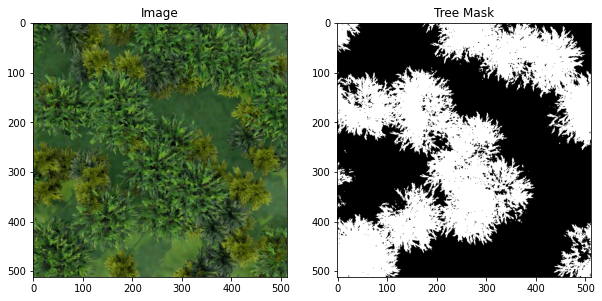

In [17]:
dataset = TreeSegmentationDataset(x_train_dir, y_train_dir)

image, mask = dataset[10]
visualize(
    image = image, 
    tree_mask = mask,
)

# DATA AUGMENTATION

In [13]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 9.1 MB/s 
     |████████████████████████████████| 948 kB 14.7 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65173 sha256=4a825acce363d9b4b1dec125df7c77d5a1f4589127165dd1a9c4d5b3d61850bf
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [14]:
import albumentations as albu

### This is where we start defining our augmentations 🤩

In [15]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5), # horizontal flips with 50% probability

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0), #scaling and rotation both

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0), #padding the images
        albu.RandomCrop(height=320, width=320, always_apply=True), #randomly cropping the images

        albu.IAAAdditiveGaussianNoise(p=0.2), # adding some gaussian noise with 20% probability

        #the one of block helps us to apply any one of the operations inside the block with a given probability
        albu.OneOf(
            [
                #some color transformations
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # image blurring
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
               #changing the hue and saturation values
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

## OUR NEW IMAGES 👻

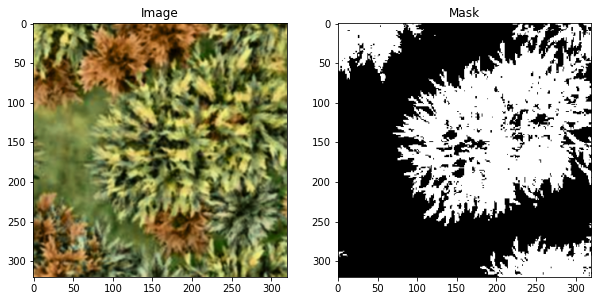

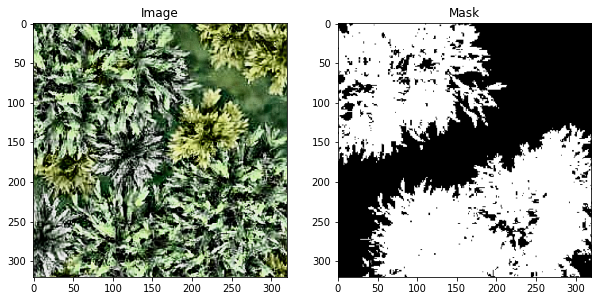

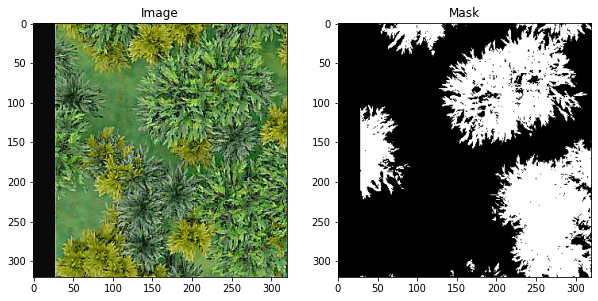

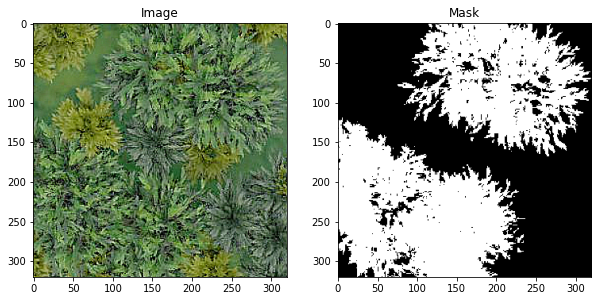

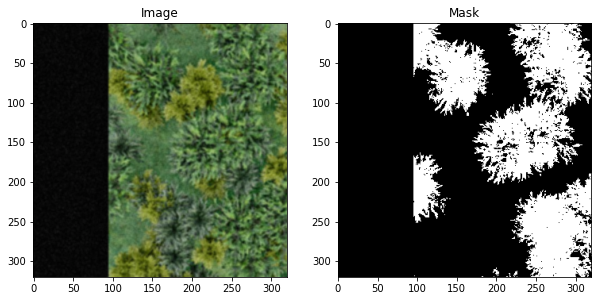

In [18]:
augmented_dataset = TreeSegmentationDataset(x_train_dir, y_train_dir, augmentation = get_training_augmentation())

for i in range(5): #visualize any 5 images and their mask
  image, mask = augmented_dataset[1]
  visualize(image = image, mask = mask)

### Insane right? I hope this will help you get started with using augmentations and I'll encourage you to tune those parameters and try out some more cool augmentations and let me know how it went 😋